In [1]:
### Importing Modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl
from collections import OrderedDict
from torchtext import vocab
import matplotlib.pyplot as plt
import os
import random
import pickle
import csv
from SA_utils import get_non_gap_indices, generate_all_point_mutants, mut2seq, find_top_n_mutations, generate_random_mut
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

/Users/nathanielblalock/miniconda3/envs/RLXF/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/nathanielblalock/miniconda3/envs/RLXF/lib/python3.8/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Extract sequences and scores
# Histogram of all sequences and unique sequences on it, too
# Heatmap of sequence aa identity heatmap

In [3]:
# Define the base path and naming conventions to load files
base_path = './SA_trials_v0/5mut_CreiLOV_max_5mut_50000steps/'
csv_filename_template = 'fitness_trajectory_5mut_CreiLOV_5mut_start_pos0_v{}.csv'
pickle_filename_template = 'best_5mut_CreiLOV_5mut_start_pos0_v{}.pickle'
files_info = {
    f"Trial {i}": {
        'fitness_csv': os.path.join(base_path, csv_filename_template.format(i)),
        'mutations_pickle': os.path.join(base_path, pickle_filename_template.format(i))
    }
    for i in range(100)
}

# Functions to process data
def get_last_fitness_value(fitness_csv_path):
    # Read the last value from the "Fitness" column in the CSV file
    with open(fitness_csv_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        fitness_values = [float(row['Fitness']) for row in csv_reader]
    return fitness_values[-1] if fitness_values else None

def get_mutations(pickle_path):
    # Load mutations from the pickle file
    with open(pickle_path, 'rb') as pkl_file:
        mutations_data = pickle.load(pkl_file)
    return mutations_data

# Define function to apply mutations to a sequence
def apply_mutations(sequence, mutations):
    seq_list = list(sequence)
    for mutation in mutations:
        position = int(mutation[1:-1])
        new_aa = mutation[-1]
        seq_list[position] = new_aa
    return ''.join(seq_list)


In [4]:
# Mutations info
WT = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'

# Iterate over both files to find the max scores, mutations, and mutated sequences
results = []
for key, file_info in files_info.items():
    last_fitness_value = get_last_fitness_value(file_info['fitness_csv'])
    mutations_data = get_mutations(file_info['mutations_pickle'])
    
    if last_fitness_value is not None and mutations_data is not None:
        mutations, _ = mutations_data  # Assuming mutations_data contains (mutations, array([fitness_value]))
        mutated_sequence = apply_mutations(WT, mutations)
        
        results.append({
            'Trial': key,
            'Fitness': last_fitness_value,
            'Mutations': mutations,
            'Sequence': mutated_sequence
        })

# Convert results into a DataFrame and display/save
results_df = pd.DataFrame(results)
results_df.to_csv('all_designs_from_100_SA_trials.csv', index=False)
results_df.head()


,Trial,Fitness,Mutations,Sequence
0,Trial 0,4.194589,"(R4D, H5S, T6S, E54A, E66S)",MAGLDSSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...
1,Trial 1,4.195799,"(R4D, T6S, E54A, E66T, K111I)",MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...
2,Trial 2,4.194699,"(R4D, H5P, T6S, E54S, E66H)",MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...
3,Trial 3,4.197739,"(R4D, H5K, T6S, H40K, E66T)",MAGLDKSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...
4,Trial 4,4.198897,"(R4D, T6S, G25T, H40K, E66H)",MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGKNARFL...


In [5]:
# Filter to unique sequences
unique_sequences_df = results_df.drop_duplicates(subset=['Sequence'])

# Display the number of unique sequences and save the unique DataFrame
print(f"Unique sequences count: {unique_sequences_df['Sequence'].nunique()}")
unique_sequences_df.to_csv('unique_designs_from_100_SA_trials.csv', index=False)
unique_sequences_df.head()

Unique sequences count: 86


,Trial,Fitness,Mutations,Sequence
0,Trial 0,4.194589,"(R4D, H5S, T6S, E54A, E66S)",MAGLDSSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...
1,Trial 1,4.195799,"(R4D, T6S, E54A, E66T, K111I)",MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...
2,Trial 2,4.194699,"(R4D, H5P, T6S, E54S, E66H)",MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...
3,Trial 3,4.197739,"(R4D, H5K, T6S, H40K, E66T)",MAGLDKSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...
4,Trial 4,4.198897,"(R4D, T6S, G25T, H40K, E66H)",MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGKNARFL...


In [6]:
def plot_heatmap_for_configuration(df, AAs, title, save_path, WT):
    
    # Unzip sequences to align positions
    alignment = tuple(zip(*df.Sequence))
    
    # Count AAs
    # AA_count = np.array([[p.count(a) for a in AAs] for p in alignment]) # raw AA counts
    AA_count = np.array([[sum(1 for seq_at_pos in alignment[pos] if seq_at_pos == a and WT[pos] != a) for a in AAs] for pos in range(len(WT))])

    Magma_r = plt.cm.magma_r(np.linspace(0, 1, 256))
    Magma_r[0] = [0, 0, 0, 0.03]  # Set the first entry (corresponding to 0 value) to white
    # Magma_r[0] = [0.9, 0.9, 0.9, 1]  # Set the first entry (corresponding to 0 value) to grey
    cmap = LinearSegmentedColormap.from_list("Modified_Magma_r", Magma_r, N=256)

    # Plot the heatmap
    plt.figure(figsize=(30,6))
    heatmap = sns.heatmap(AA_count.T, cmap=cmap, square=True, linewidths=0.003, linecolor='0.7')
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Count of Amino Acid Mutations', fontsize=16)
    cbar.ax.tick_params(labelsize=12)
    pos = cbar.ax.get_position()  # Get the original position
    cbar.ax.set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])  # Shift the colorbar closer
    plt.yticks(np.arange(len(AAs)) + 0.5, AAs)
    plt.xlabel('Position', fontsize=18)
    plt.ylabel('Amino Acid', fontsize=18)
    plt.title(title)

    # Add black dots for WT sequence
    for pos, aa in enumerate(WT):
        if aa in AAs:  # Check if the AA is one of the considered AAs
            aa_index = AAs.index(aa)
            # Plot black dot; adjust dot size with 's' as needed
            plt.scatter(pos + 0.5, aa_index + 0.5, color='black', s=30)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='WT')]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Save the plot
    plt.savefig(save_path)
    plt.show()
    plt.close()

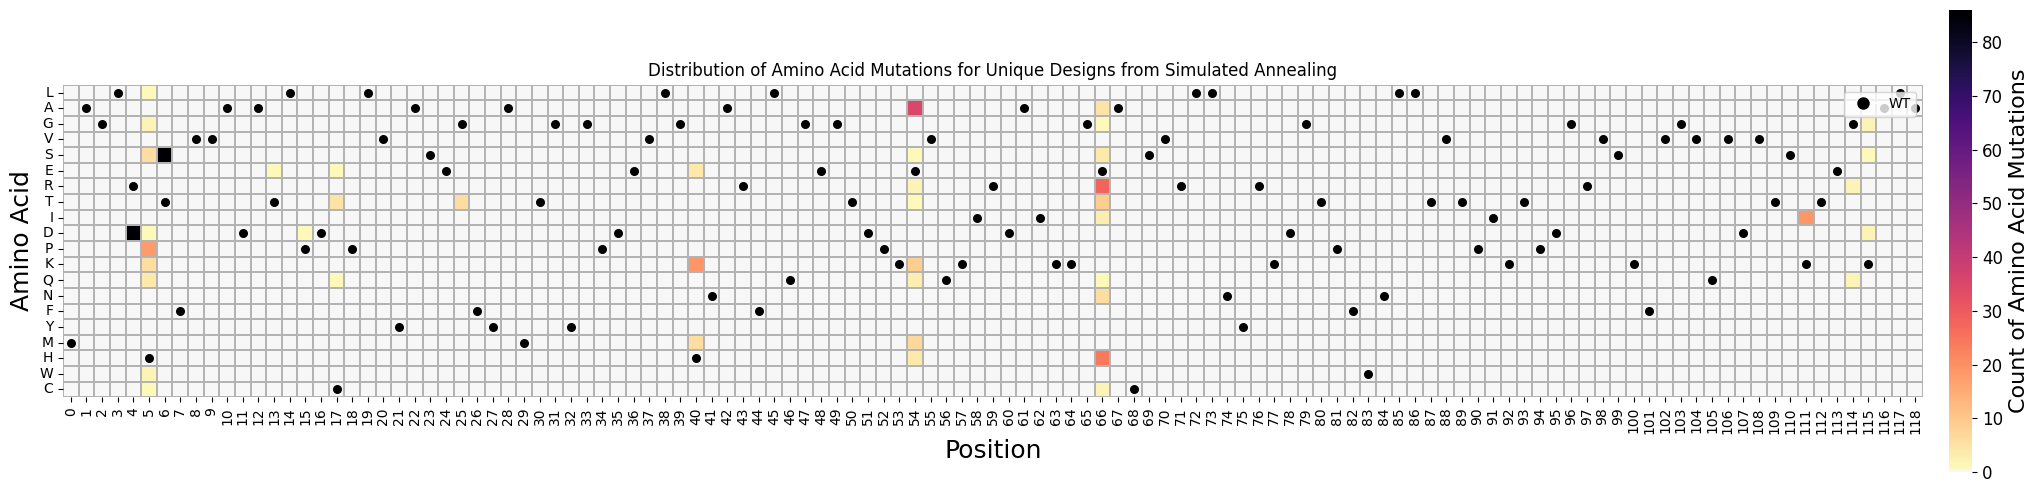

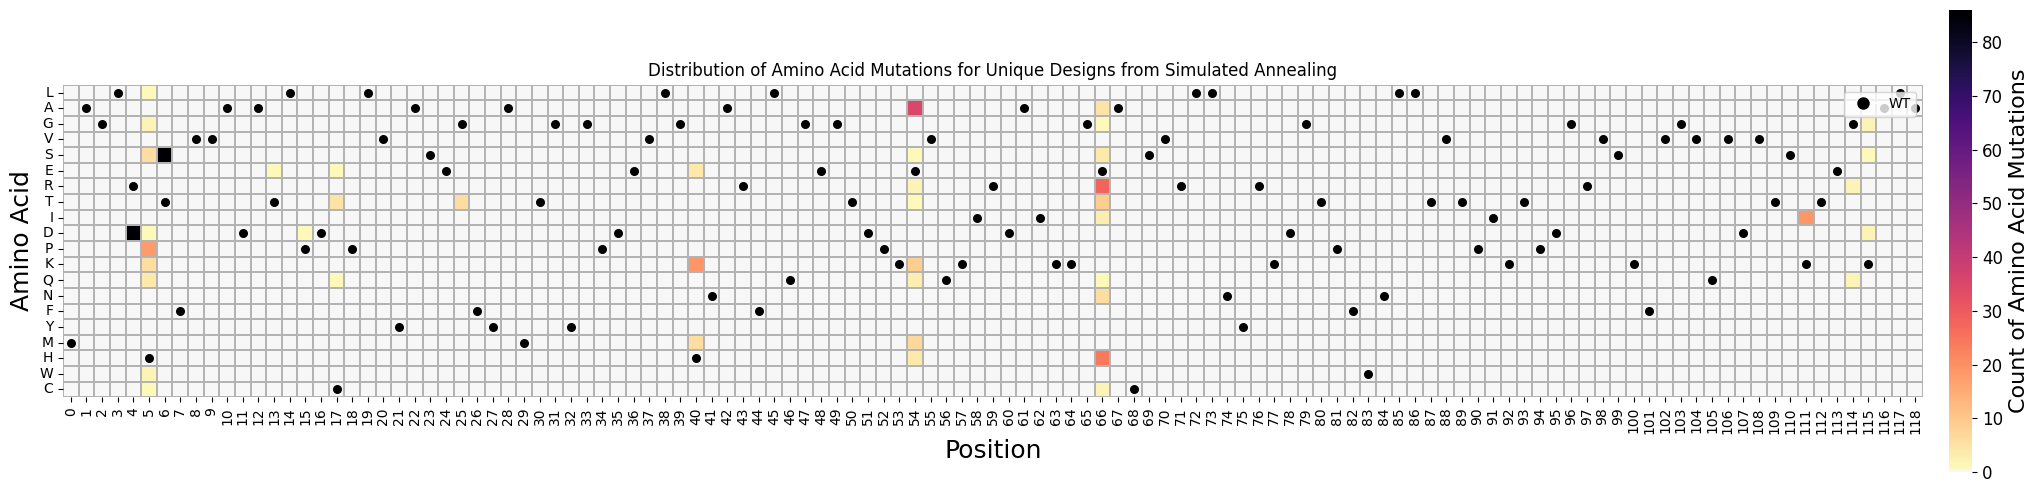

In [7]:
# Amino acids including gap character
AAs = 'LAGVSERTIDPKQNFYMHWC'

# Plot for C4
plot_heatmap_for_configuration(unique_sequences_df, AAs,
                               'Distribution of Amino Acid Mutations for Unique Designs from Simulated Annealing',
                               './SA_design_data_mutation_distribution.png', WT)

plot_heatmap_for_configuration(unique_sequences_df, AAs,
                               'Distribution of Amino Acid Mutations for Unique Designs from Simulated Annealing',
                               './SA_design_data_mutation_distribution.svg', WT)


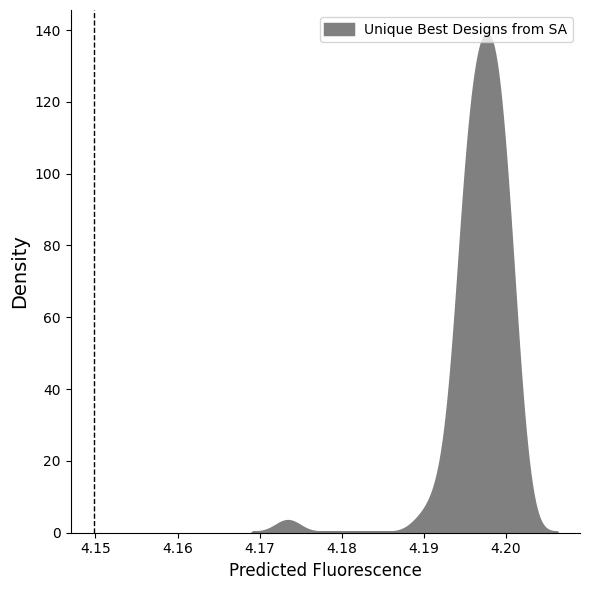

In [8]:
# Constants for the mean and standard deviation
predicted_wt_score = 4.1498 # this is predicted WT score # mean log exp score: 4.094413241

# Plot histogram
fig, ax = plt.subplots(figsize=(6, 6))

# Plot histograms for the models7
sns.kdeplot(unique_sequences_df['Fitness'], color='grey', ax=ax, linewidth=2.5, fill=True, alpha=1, label='Unique Best Designs from SA')
ax.axvline(predicted_wt_score, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Fluorescence', fontsize=12)
ax.set_ylabel('Density', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim(3.6, 4.2)
# ax.set_ylim(0, 80)
ax.legend()
plt.tight_layout()

# Save the plot
plt.savefig(f'./SA_design_data_scores.svg')
plt.savefig(f'./SA_design_data_scores.png')


In [9]:
# Find the maximum fitness value
max_fitness_value = unique_sequences_df['Fitness'].max()

# Locate the row with the maximum fitness value
max_fitness_row = unique_sequences_df[unique_sequences_df['Fitness'] == max_fitness_value]

# Display the sequence and max fitness value
print("Row with Maximum Fitness Value:")
max_fitness_row

Row with Maximum Fitness Value:


,Trial,Fitness,Mutations,Sequence
6,Trial 6,4.201938,"(R4D, H5P, T6S, E54A, E66R)",MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...


In [10]:
# Best sequence from Simulated Annealing
seq = max_fitness_row['Sequence'].iloc[0]
seq

'MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKAVQKIRDAIKKGRACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'

In [11]:
# Define the path template for the pickle files
path_template = './SA_trials_v1/5mut_CreiLOV_max_5mut_50000steps/close_sequences_5mut_start_pos0_v{}.pickle'

# Initialize a set to track unique sequences and a list to store unique sequence-fitness pairs
seen_sequences = set()
unique_close_sequences = []

# Loop through versions v0 to v99
for v in range(100):
    pickle_file_path = path_template.format(v)
    try:
        # Load each pickle file
        with open(pickle_file_path, 'rb') as file:
            close_sequences_data = pickle.load(file)
        
        # Process each entry in the data
        for mutations, fitness_array in close_sequences_data:
            mutated_sequence = apply_mutations(WT, mutations)
            fitness_value = fitness_array[0]  # Extract the fitness value
            
            # Only add sequences that have not been seen
            if mutated_sequence not in seen_sequences:
                seen_sequences.add(mutated_sequence)
                unique_close_sequences.append((mutated_sequence, fitness_value))
    
    except FileNotFoundError:
        print(f"File {pickle_file_path} not found. Skipping.")
        continue  # Skip files that don't exist and continue with the loop

# Create a DataFrame from the unique sequences list
unique_close_sequences_df = pd.DataFrame(unique_close_sequences, columns=['Sequence', 'Fitness'])

# Display or save the DataFrame
print(unique_close_sequences_df)
unique_close_sequences_df.to_csv('unique_close_sequences_fitness.csv', index=False)

                                                 Sequence   Fitness
0       MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.160091
1       MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.158341
2       MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.152294
3       MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.158983
4       MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.151357
...                                                   ...       ...
780739  MAGLDGSFVVADATHPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.187863
780740  MAGLRGSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.158073
780741  MAGLDGSFVVADATLPDCPLVYASFGFYAMTGYGPDEVLGHNARFL...  4.178017
780742  MAGLDGSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.160207
780743  MAGLDGSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...  4.191377

[780744 rows x 2 columns]


In [12]:
# Set the random seed for reproducibility
seed = 42

# Sample 1000 unique variants randomly
random_sample = unique_close_sequences_df.sample(n=1000, random_state=seed)
random_sample.to_csv('random_sample_variants.csv', index=False)
random_sample.head()

,Sequence,Fitness
224836,MAGLRHSFVVADATDPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...,4.161769
337412,MAGLDFSFVVADATLPDCPLVYASEGFYAMTGYGPEEVLGHNARFL...,4.174712
681590,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLKHNARFL...,4.171491
292148,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.171832
292396,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGMNARFL...,4.161421


In [13]:
# Sample 1000 unique variants with the greatest fitness
top_fitness_sample = unique_close_sequences_df.nlargest(1000, 'Fitness')
top_fitness_sample.to_csv('top_fitness_sample_variants.csv', index=False)
top_fitness_sample.head()

,Sequence,Fitness
56773,MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201938
171514,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...,4.201278
741822,MAGLDSSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201255
364602,MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201134
572739,MAGLDKSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201097


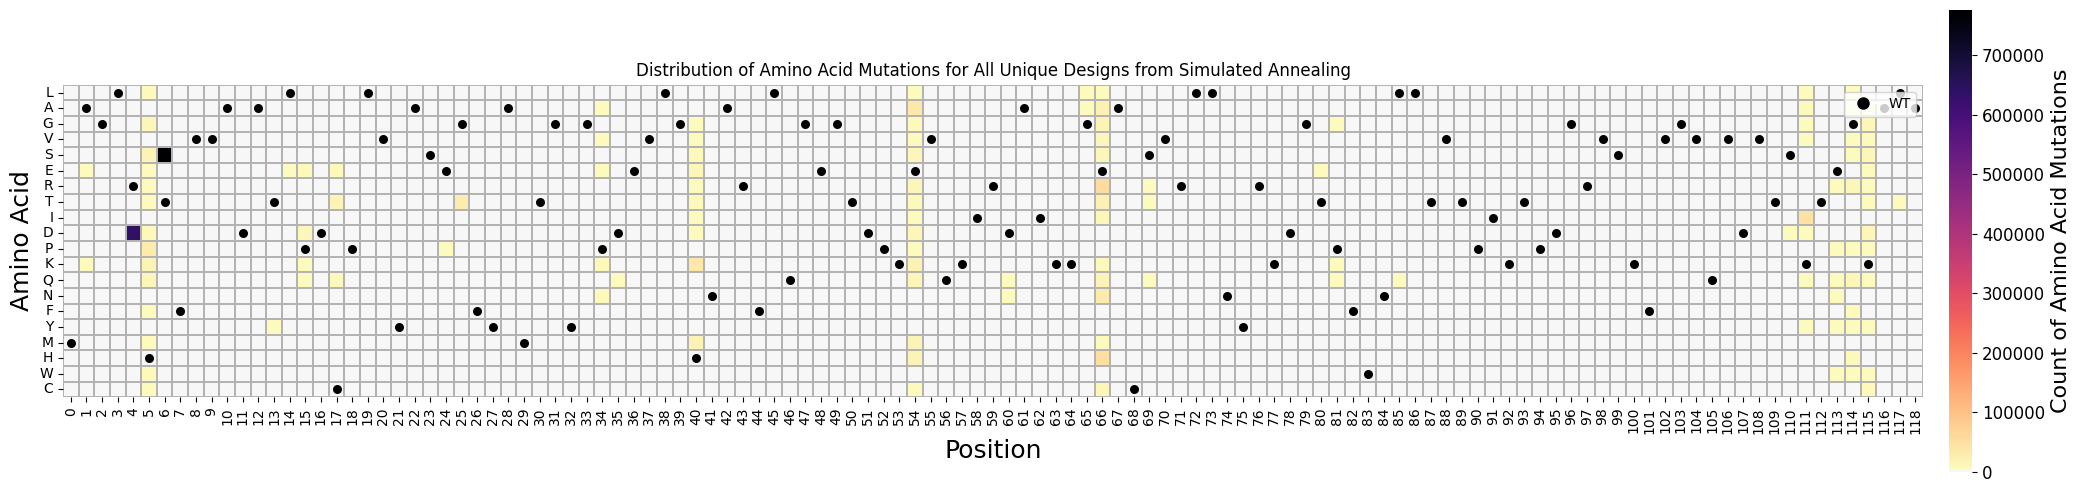

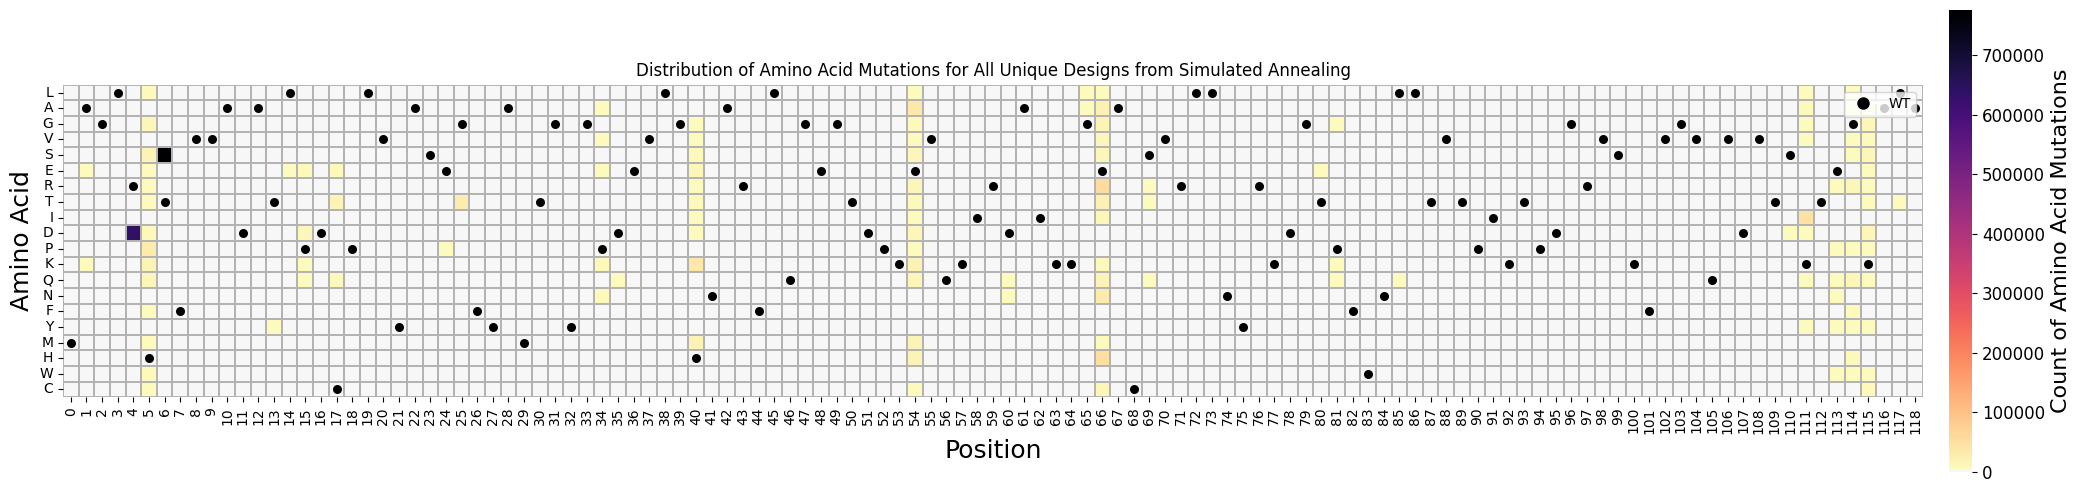

In [14]:
# Amino acids including gap character
AAs = 'LAGVSERTIDPKQNFYMHWC'

# Plot for C4
plot_heatmap_for_configuration(unique_close_sequences_df, AAs,
                               'Distribution of Amino Acid Mutations for All Unique Designs from Simulated Annealing',
                               './SA_close_sequences_data_mutation_distribution.png', WT)

plot_heatmap_for_configuration(unique_close_sequences_df, AAs,
                               'Distribution of Amino Acid Mutations for All Unique Designs from Simulated Annealing',
                               './SA_close_sequences_data_mutation_distribution.svg', WT)


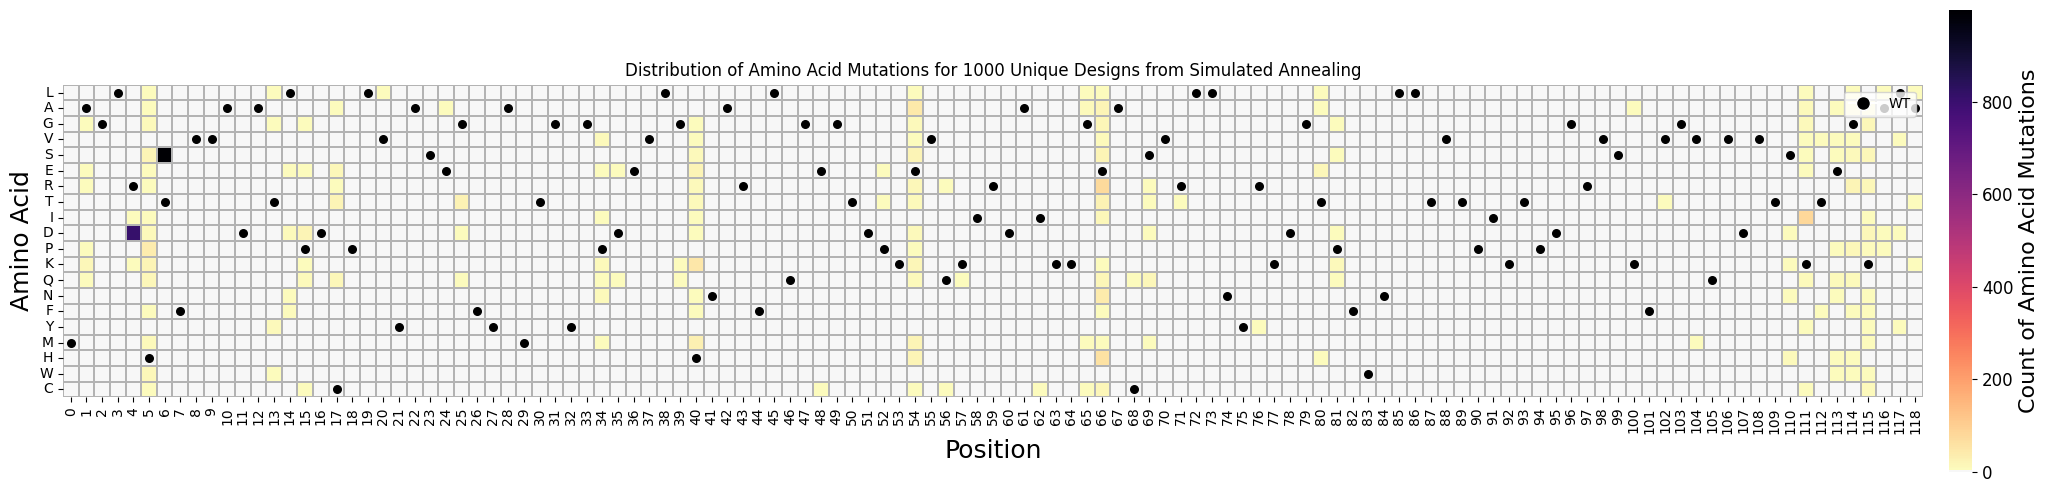

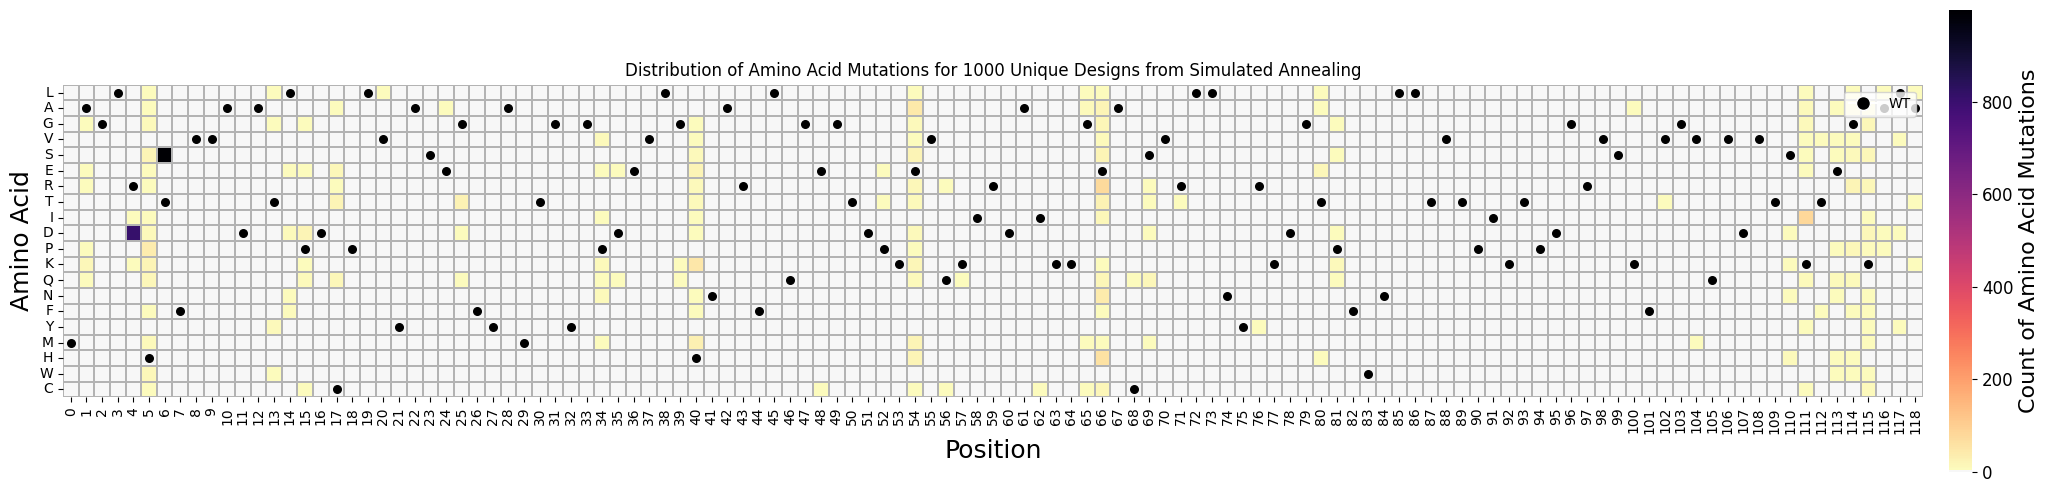

In [15]:
# Amino acids including gap character
AAs = 'LAGVSERTIDPKQNFYMHWC'

# Plot for C4
plot_heatmap_for_configuration(random_sample, AAs,
                               'Distribution of Amino Acid Mutations for 1000 Unique Designs from Simulated Annealing',
                               './SA_1000_close_sequences_data_mutation_distribution.png', WT)

plot_heatmap_for_configuration(random_sample, AAs,
                               'Distribution of Amino Acid Mutations for 1000 Unique Designs from Simulated Annealing',
                               './SA_1000_close_sequences_data_mutation_distribution.svg', WT)


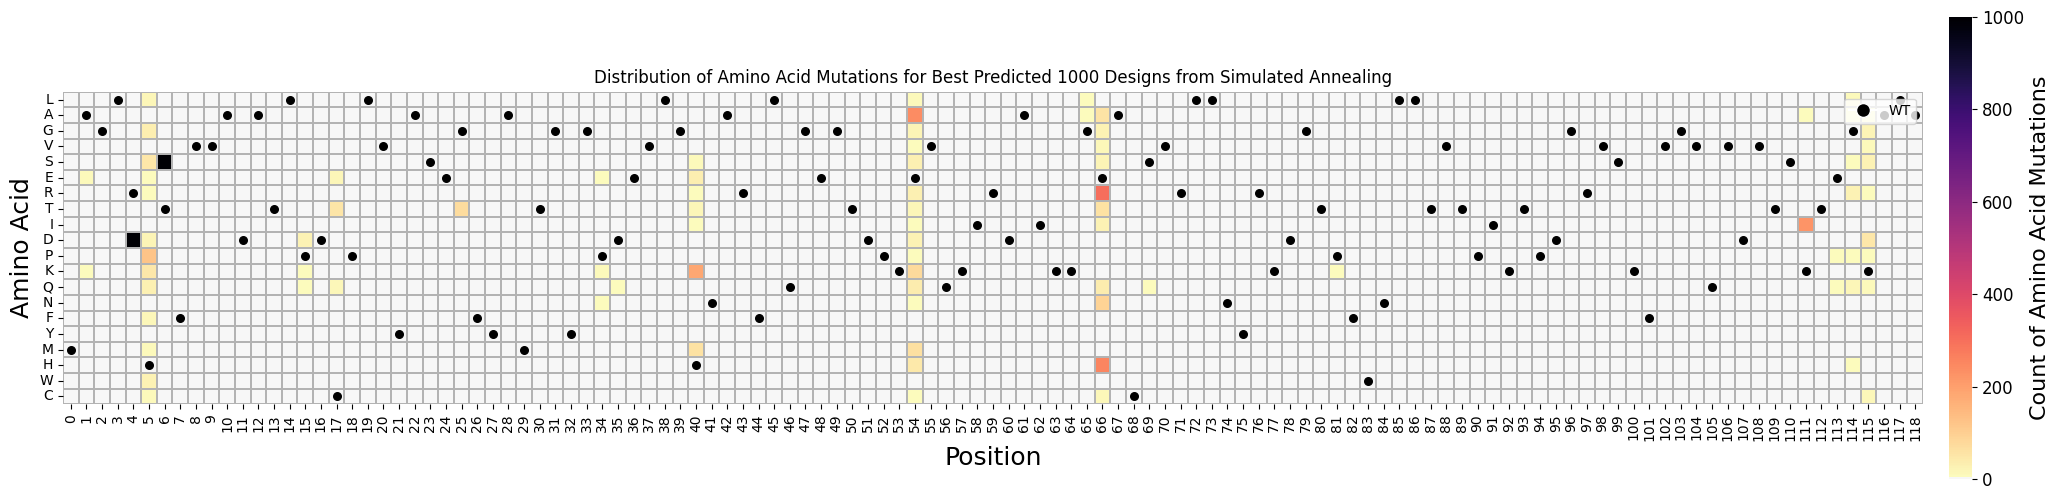

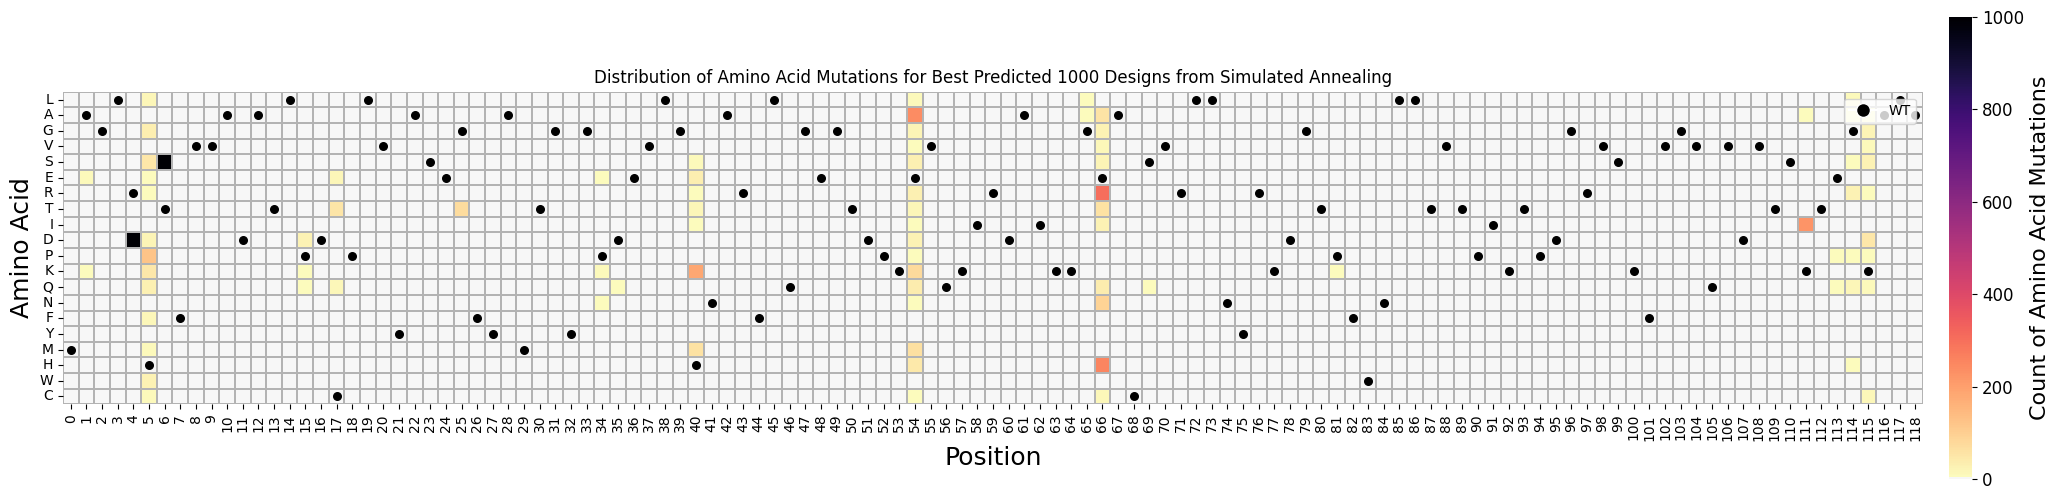

In [16]:
# Amino acids including gap character
AAs = 'LAGVSERTIDPKQNFYMHWC'

# Plot for C4
plot_heatmap_for_configuration(top_fitness_sample, AAs,
                               'Distribution of Amino Acid Mutations for Best Predicted 1000 Designs from Simulated Annealing',
                               './SA_1000_best_sequences_data_mutation_distribution.png', WT)

plot_heatmap_for_configuration(top_fitness_sample, AAs,
                               'Distribution of Amino Acid Mutations for Best Predicted 1000 Designs from Simulated Annealing',
                               './SA_1000_best_sequences_data_mutation_distribution.svg', WT)


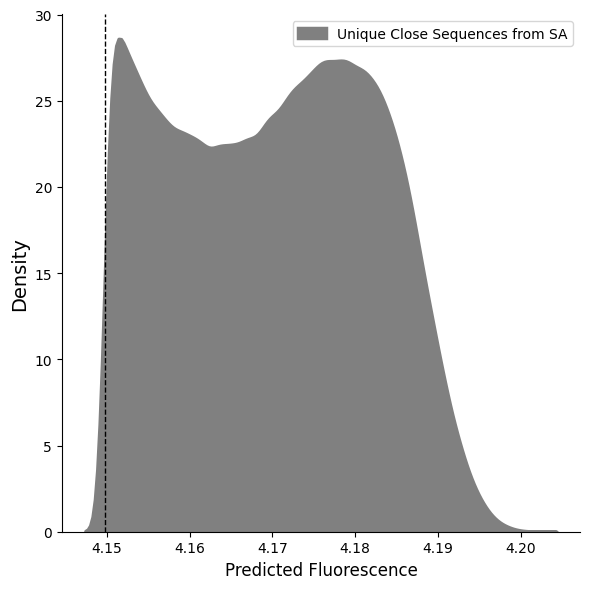

In [17]:
# Constants for the mean and standard deviation
predicted_wt_score = 4.1498 # this is predicted WT score # mean log exp score: 4.094413241

# Plot histogram
fig, ax = plt.subplots(figsize=(6, 6))

# Plot histograms for the models7
sns.kdeplot(unique_close_sequences_df['Fitness'], color='grey', ax=ax, linewidth=2.5, fill=True, alpha=1, label='Unique Close Sequences from SA')
ax.axvline(predicted_wt_score, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Fluorescence', fontsize=12)
ax.set_ylabel('Density', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()

# Save the plot
plt.savefig(f'./SA_close_sequences_data_scores.svg')
plt.savefig(f'./SA_close_sequences_data_scores.png')


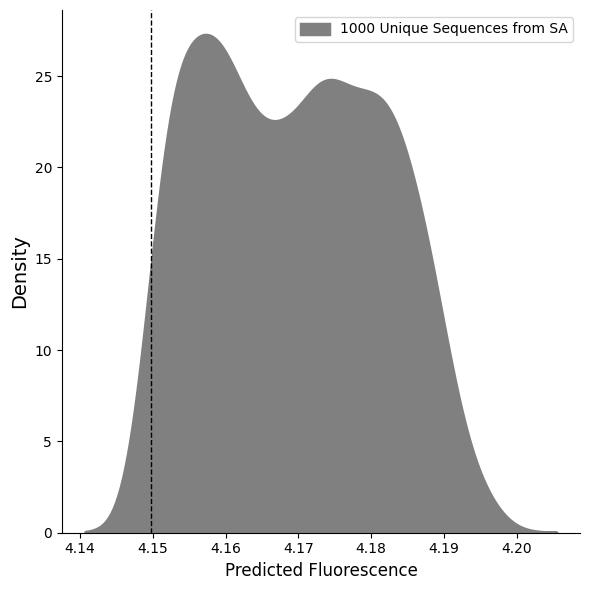

In [18]:
# Constants for the mean and standard deviation
predicted_wt_score = 4.1498 # this is predicted WT score # mean log exp score: 4.094413241

# Plot histogram
fig, ax = plt.subplots(figsize=(6, 6))

# Plot histograms for the models7
sns.kdeplot(random_sample['Fitness'], color='grey', ax=ax, linewidth=2.5, fill=True, alpha=1, label='1000 Unique Sequences from SA')
ax.axvline(predicted_wt_score, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Fluorescence', fontsize=12)
ax.set_ylabel('Density', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()

# Save the plot
plt.savefig(f'./SA_1000_close_sequences_data_scores.svg')
plt.savefig(f'./SA_1000_close_sequences_data_scores.png')


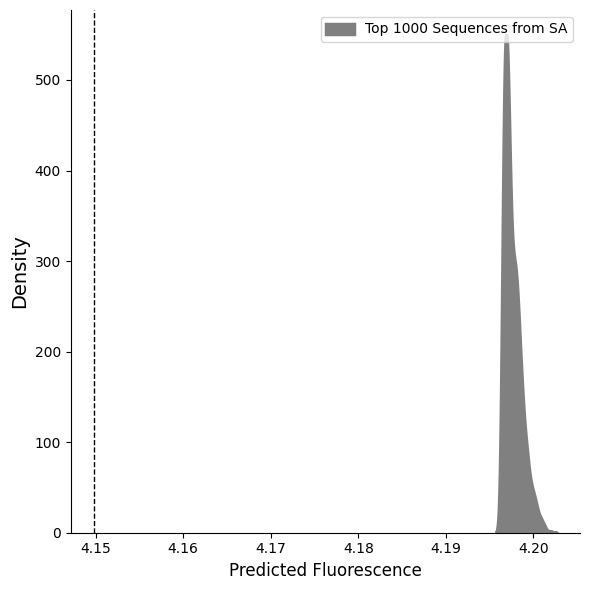

In [19]:
# Constants for the mean and standard deviation
predicted_wt_score = 4.1498 # this is predicted WT score # mean log exp score: 4.094413241

# Plot histogram
fig, ax = plt.subplots(figsize=(6, 6))

# Plot histograms for the models7
sns.kdeplot(top_fitness_sample['Fitness'], color='grey', ax=ax, linewidth=2.5, fill=True, alpha=1, label='Top 1000 Sequences from SA')
ax.axvline(predicted_wt_score, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Predicted Fluorescence', fontsize=12)
ax.set_ylabel('Density', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()

# Save the plot
plt.savefig(f'./SA_1000_best_sequences_data_scores.svg')
plt.savefig(f'./SA_1000_best_sequences_data_scores.png')


In [20]:
WT = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'
CreiLOV = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNCRFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'

# Process unique_close_sequences_df, random_sample, top_fitness_sample, and unique_sequences_df dataframes
# Count number of mutations relative to WT
# State the mutations as a list with the typical protein engineering format Ex.) T7S
# Add column with list of numbers where positions mutated
# Created a masked sequence column where Sequence amino acids do not match CreiLOV (not WT)

In [27]:
# Define WT and CreiLOV sequences
WT =      'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'
CreiLOV = 'MAGLRHTFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNCRFLQGEGTDPKEVQKIRDAIKKGEACSVRLLNYRKDGTPFWNLLTVTPIKTPDGRVSKFVGVQVDVTSKTEGKALA'

# Example dataframes
dataframes_to_process = {
    'unique_close_sequences_df': unique_close_sequences_df,
    'random_sample': random_sample,
    'top_fitness_sample': top_fitness_sample,
    'unique_sequences_df': unique_sequences_df
}

# Function to calculate mutations, positions, and masked sequence
def process_sequence(seq, wt, crei_lov):
    # Find mutations and their positions
    mutations = []
    positions = []
    for i, (wt_res, seq_res) in enumerate(zip(wt, seq), 1):
        if seq_res != wt_res:
            mutations.append(f"{wt_res}{i}{seq_res}")
            positions.append(i)
    
    # Create masked sequence relative to CreiLOV
    masked_sequence = ''.join([aa if aa == cl_aa else '<mask>' for aa, cl_aa in zip(seq, crei_lov)])
    
    return mutations, positions, masked_sequence

# Process each dataframe
for name, df in dataframes_to_process.items():
    # Ensure the columns 'Sequence' exists
    if 'Sequence' not in df.columns:
        print('Sequence column does not exist.')
        continue
    
    # Apply the function to each sequence
    df['Mutations'], df['Mutation_Positions'], df['Masked_Sequence'] = zip(*df['Sequence'].apply(lambda x: process_sequence(x, WT, CreiLOV)))
    df['MutationCount'] = df['Mutations'].apply(len)  # Count of mutations

    dataframes_to_process[name] = df  # Update processed DataFrame


/var/folders/bx/wt_7f93n19z_0q92_mfgy2y80000gn/T/ipykernel_33328/4212504751.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mutations'], df['Mutation_Positions'], df['Masked_Sequence'] = zip(*df['Sequence'].apply(lambda x: process_sequence(x, WT, CreiLOV)))
/var/folders/bx/wt_7f93n19z_0q92_mfgy2y80000gn/T/ipykernel_33328/4212504751.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MutationCount'] = df['Mutations'].apply(len)  # Count of mutations


In [28]:
# Reorder columns for each processed dataframe
for name, df in dataframes_to_process.items():
    df = df[['Masked_Sequence', 'Sequence', 'Mutations', 'MutationCount', 'Fitness', 'Mutation_Positions']]

In [29]:
random_sample.head()

,Sequence,Fitness,Mutations,Mutation_Positions,Masked_Sequence,MutationCount
224836,MAGLRHSFVVADATDPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...,4.161769,"[T7S, L15D, H41K, Q57M, E67A]","[7, 15, 41, 57, 67]",MAGLRH<mask>FVVADAT<mask>PDCPLVYASEGFYAMTGYGPD...,5
337412,MAGLDFSFVVADATLPDCPLVYASEGFYAMTGYGPEEVLGHNARFL...,4.174712,"[R5D, H6F, T7S, D36E, K64E]","[5, 6, 7, 36, 64]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
681590,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLKHNARFL...,4.171491,"[R5D, T7S, G40K, E67D, T90F]","[5, 7, 40, 67, 90]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
292148,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.171832,"[R5D, T7S, A62I, E67R, G115P]","[5, 7, 62, 67, 115]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
292396,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGMNARFL...,4.161421,"[T7S, H41M, E55D, E67R, A68K]","[7, 41, 55, 67, 68]",MAGLRH<mask>FVVADATLPDCPLVYASEGFYAMTGYGPDEVLG<...,5


In [30]:
top_fitness_sample.head()

,Sequence,Fitness,Mutations,Mutation_Positions,Masked_Sequence,MutationCount
56773,MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201938,"[R5D, H6P, T7S, E55A, E67R]","[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
171514,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...,4.201278,"[R5D, T7S, H41K, E55A, E67R]","[5, 7, 41, 55, 67]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
741822,MAGLDSSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201255,"[R5D, H6S, T7S, E55A, E67R]","[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
364602,MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201134,"[R5D, H6P, T7S, E55K, E67R]","[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
572739,MAGLDKSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201097,"[R5D, H6K, T7S, E55A, E67R]","[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5


In [31]:
unique_sequences_df.head()

,Trial,Fitness,Mutations,Sequence,Mutation_Positions,Masked_Sequence,MutationCount
0,Trial 0,4.194589,"[R5D, H6S, T7S, E55A, E67S]",MAGLDSSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,"[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
1,Trial 1,4.195799,"[R5D, T7S, E55A, E67T, K112I]",MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,"[5, 7, 55, 67, 112]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
2,Trial 2,4.194699,"[R5D, H6P, T7S, E55S, E67H]",MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,"[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
3,Trial 3,4.197739,"[R5D, H6K, T7S, H41K, E67T]",MAGLDKSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGKNARFL...,"[5, 6, 7, 41, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5
4,Trial 4,4.198897,"[R5D, T7S, G26T, H41K, E67H]",MAGLDHSFVVADATLPDCPLVYASETFYAMTGYGPDEVLGKNARFL...,"[5, 7, 26, 41, 67]",MAGL<mask>H<mask>FVVADATLPDCPLVYASE<mask>FYAMT...,5


In [32]:
unique_close_sequences_df.head()

,Sequence,Fitness,Mutations,Mutation_Positions,Masked_Sequence,MutationCount
0,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.160091,"[R5D, T7S, E49S, K58P, K65I]","[5, 7, 49, 58, 65]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
1,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.158341,"[R5D, T7S, P53D, K58P, T110W]","[5, 7, 53, 58, 110]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
2,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.152294,"[T7S, E55H, I63N, E67R, P82V]","[7, 55, 63, 67, 82]",MAGLRH<mask>FVVADATLPDCPLVYASEGFYAMTGYGPDEVLGH...,5
3,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.158983,"[T7S, E55H, E67R, P82V, E114M]","[7, 55, 67, 82, 114]",MAGLRH<mask>FVVADATLPDCPLVYASEGFYAMTGYGPDEVLGH...,5
4,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.151357,"[T7S, E67R, P82V, S100F, E114M]","[7, 67, 82, 100, 114]",MAGLRH<mask>FVVADATLPDCPLVYASEGFYAMTGYGPDEVLGH...,5


In [34]:
# Save the DataFrame to a pickle file
unique_sequences_df.to_pickle("SFT_dataset_df_max_fitness_unique_designs_from_SA.pkl")
unique_close_sequences_df.to_pickle("SFT_dataset_all_unique_designs_from_SA.pkl")
random_sample.to_pickle("SFT_dataset_df_1000_unique_designs_from_SA.pkl")
top_fitness_sample.to_pickle("SFT_dataset_df_best_1000_unique_designs_from_SA.pkl")

print(len(unique_sequences_df))
print(len(unique_close_sequences_df))
print(len(random_sample))
print(len(top_fitness_sample))
    

# Confirm the file has been saved
print("Dataset has been saved as a pickle file.")

86
780744
1000
1000
Dataset has been saved as a pickle file.


In [40]:
# Find the maximum fitness value
max_fitness_value = unique_close_sequences_df['Fitness'].max()

# Locate the row with the maximum fitness value
max_fitness_row = unique_close_sequences_df[unique_close_sequences_df['Fitness'] == max_fitness_value]

# Display the sequence and max fitness value
print("Row with Maximum Fitness Value:")
max_fitness_row

Row with Maximum Fitness Value:


,Sequence,Fitness,Mutations,Mutation_Positions,Masked_Sequence,MutationCount
56773,MAGLDPSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.201938,"[R5D, H6P, T7S, E55A, E67R]","[5, 6, 7, 55, 67]",MAGL<mask><mask><mask>FVVADATLPDCPLVYASEGFYAMT...,5


In [42]:
# Find the maximum fitness value
min_fitness_value = unique_close_sequences_df['Fitness'].min()

# Locate the row with the maximum fitness value
min_fitness_row = unique_close_sequences_df[unique_close_sequences_df['Fitness'] == min_fitness_value]

# Display the sequence and min fitness value
print("Row with Minimum Fitness Value:")
min_fitness_row

Row with Minimum Fitness Value:


,Sequence,Fitness,Mutations,Mutation_Positions,Masked_Sequence,MutationCount
675151,MAGLDHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLGHNARFL...,4.1498,"[R5D, T7S, D61P, K64D, K116G]","[5, 7, 61, 64, 116]",MAGL<mask>H<mask>FVVADATLPDCPLVYASEGFYAMTGYGPD...,5
758899,MAGLRHSFVVADATLPDCPLVYASEGFYAMTGYGPDEVLQHNARFL...,4.1498,"[T7S, G40Q, S70M, W84Q, K112A]","[7, 40, 70, 84, 112]",MAGLRH<mask>FVVADATLPDCPLVYASEGFYAMTGYGPDEVL<m...,5
